<a href="https://colab.research.google.com/github/mariusbiteau/Buildings_Electrical-Consumption_CO2-Emissions_Prediction/blob/main/Analysis_Buildings_Electrical_Consumption_CO2_Emissions_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of electrical consumption and CO2 emissions of non-residential buildings.

You work for the city of Seattle. To achieve its goal of a carbon-neutral city by 2050, your team is taking a close look at emissions from non-residential buildings.

### About the Dataset

This is a dataset hosted by the City of Seattle. The city has an open data platform found here and they update their information according the amount of data that is brought in. 

Update Frequency: This dataset is updated quarterly.

The datasets has as datapoint each building (TBD products) and for each, we have TBD columns which are separated in  sections :

TBD


### Project Goal

Thorough surveys have been carried out by your agents in 2015 and 2016. However, these readings are expensive to obtain, and based on those already taken, you want to try to predict the CO2 emissions and total energy consumption of buildings for which they have not yet been measured.

You are also looking to assess the value of the ENERGY STAR Score for emissions prediction, which is tedious to calculate with the approach your team is currently using.

Objectives of this analysis notebook :

- Perform a brief EDA.
- Test different prediction models in order to better answer the problem.

 have 2 variables to predict; the energy consumption of a site and its CO2 emissions. I also have to evaluate the interest of the Energy Star Score in predicting carbon emissions.

The energy consumption (kWh or kBtu) of a building is composed of different factors, in order of importance :

Its natural characteristics (placement, orientation, etc.),
Its level of insulation (attic, walls, glazing, etc.),
Its airtightness level (VMC, electrical boxes, gaskets, etc... ),
The performance of its equipment (hot water production, user equipment),
Its mode of heating (electricity, gas, wood, etc...)
CO2 emissions are regulated by direct and indirect factors. For example, an electrical energy produced by nuclear fission will emit less CO2 than an electrical energy produced by coal, this is an indirect factor. If heat is produced directly using natural gas, it is a direct factor in CO2 emissions.

We speak of emissions in grams per kWh or kBtu, so CO2 emissions are correlated to energy consumption.

The objective of this first work is to be able to extract the variables that best correspond to the criteria mentioned above, in order to obtain the most efficient models.

In [44]:
# Essentials
from google.colab import drive
import pandas as pd
import numpy as np
import json
import time
import six

# Plots
import seaborn as sns
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Stats
import math
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

# Misc
from sklearn import metrics
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Execution Time
!pip install ipython-autotime
%load_ext autotime

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.36 s (started: 2021-01-10 08:41:23 +00:00)


## 1. Data Import

In [3]:
drive.mount('/content/drive')
csv_seattle = '/content/drive/My Drive/OC_DataScientist/P4/df_seattle_modelization.csv'
df = pd.read_csv(csv_seattle)

Mounted at /content/drive
time: 21 s (started: 2021-01-10 08:12:23 +00:00)


## 2. Data Description

##### Show data header


In [4]:
df.head(3)

,Unnamed: 0,OSEBuildingID,DataYear,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
0,0,1,2015,MAYFLOWER PARK HOTEL,88,Hotel,1.0,4.0,88434,1.000000,65.0,Electricity,6981428.0,0.527995,0.182253,0.289773,0.0,249.43,7,47.612190,-122.337997
1,1,2,2015,PARAMOUNT HOTEL,19,Hotel,1.0,4.0,103566,0.854547,51.0,NaturalGas,8354235.0,0.467477,0.532542,0.000000,0.0,263.51,7,47.613106,-122.333358
2,2,3,2015,WESTIN HOTEL,46,Hotel,1.0,4.0,961990,1.000000,18.0,Electricity,73130656.0,0.680459,0.050730,0.268839,0.0,2061.48,7,47.613349,-122.337699


time: 33.1 ms (started: 2021-01-10 08:12:44 +00:00)


##### Show data info


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    3102 non-null   int64  
 1   OSEBuildingID                 3102 non-null   int64  
 2   DataYear                      3102 non-null   int64  
 3   PropertyName                  3102 non-null   object 
 4   BuildingAge                   3102 non-null   int64  
 5   PrimaryPropertyType           3102 non-null   object 
 6   NumberofBuildings             3102 non-null   float64
 7   Binned_Floors                 3079 non-null   float64
 8   PropertyGFATotal              3102 non-null   int64  
 9   GFABuildings_prop             3102 non-null   float64
 10  ENERGYSTARScore               2065 non-null   float64
 11  MainEnergy                    3102 non-null   object 
 12  SiteEnergyUse(kBtu)           3102 non-null   float64
 13  Ele

##### Fix data types


In [6]:
df.PropertyName = df.PropertyName.astype('category')
df.PrimaryPropertyType = df.PrimaryPropertyType.astype('category')
df.MainEnergy = df.MainEnergy.astype('category')
df = df.drop(['Unnamed: 0'], axis=1)

time: 13.8 ms (started: 2021-01-10 08:12:44 +00:00)


Now, let's check our new data types and column names:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OSEBuildingID                 3102 non-null   int64   
 1   DataYear                      3102 non-null   int64   
 2   PropertyName                  3102 non-null   category
 3   BuildingAge                   3102 non-null   int64   
 4   PrimaryPropertyType           3102 non-null   category
 5   NumberofBuildings             3102 non-null   float64 
 6   Binned_Floors                 3079 non-null   float64 
 7   PropertyGFATotal              3102 non-null   int64   
 8   GFABuildings_prop             3102 non-null   float64 
 9   ENERGYSTARScore               2065 non-null   float64 
 10  MainEnergy                    3102 non-null   category
 11  SiteEnergyUse(kBtu)           3102 non-null   float64 
 12  Electricity                   3102 non-null   fl

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [8]:
df.describe()

,OSEBuildingID,DataYear,BuildingAge,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
count,3102.000000,3102.000000,3102.000000,3102.000000,3079.000000,3.102000e+03,3102.000000,2065.000000,3.102000e+03,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000
mean,15920.698259,2015.485816,53.815603,1.089297,2.443326,1.145883e+05,0.934572,63.848426,8.030760e+06,0.706203,0.273337,0.020395,0.000044,178.629001,4.382979,47.615868,-122.333445
std,13331.224511,0.499879,32.743955,1.169077,1.129937,1.977410e+05,0.150500,28.738155,2.082894e+07,0.260824,0.261913,0.089330,0.001321,657.974395,2.202357,0.047740,0.023942
min,1.000000,2015.000000,1.000000,0.000000,1.000000,1.128500e+04,-1.502318,1.000000,1.144100e+04,0.000000,0.000000,0.000000,0.000000,0.080000,1.000000,47.509435,-122.411820
25%,586.500000,2015.000000,27.000000,1.000000,1.000000,2.938000e+04,1.000000,45.000000,1.228871e+06,0.498926,0.000000,0.000000,0.000000,19.822500,2.000000,47.585957,-122.343233
50%,21125.000000,2015.000000,50.000000,1.000000,2.000000,4.885000e+04,1.000000,71.000000,2.602079e+06,0.721463,0.231826,0.000000,0.000000,49.060000,4.000000,47.612276,-122.333223
75%,24535.500000,2016.000000,86.000000,1.000000,3.000000,1.046775e+05,1.000000,88.000000,7.141995e+06,0.999998,0.484631,0.000000,0.000000,140.640000,7.000000,47.648351,-122.322623
max,50226.000000,2016.000000,116.000000,39.000000,4.000000,2.200000e+06,1.000029,100.000000,4.483853e+08,1.000087,1.000000,0.830998,0.046463,16870.980000,7.000000,47.733870,-122.258795


time: 64.7 ms (started: 2021-01-10 08:12:45 +00:00)


##### Show if there are missing datapoints¶


In [9]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

OSEBuildingID , 0.0
DataYear , 0.0
PropertyName , 0.0
BuildingAge , 0.0
PrimaryPropertyType , 0.0
NumberofBuildings , 0.0
Binned_Floors , 0.74
PropertyGFATotal , 0.0
GFABuildings_prop , 0.0
ENERGYSTARScore , 33.43
MainEnergy , 0.0
SiteEnergyUse(kBtu) , 0.0
Electricity , 0.0
NaturalGas , 0.0
SteamUse , 0.0
OtherFuelUse , 0.0
GHGEmissions(MetricTonsCO2e) , 0.0
CouncilDistrictCode , 0.0
Latitude , 0.0
Longitude , 0.0
time: 44.1 ms (started: 2021-01-10 08:12:45 +00:00)


In [10]:
print(df.isnull().sum())

OSEBuildingID                      0
DataYear                           0
PropertyName                       0
BuildingAge                        0
PrimaryPropertyType                0
NumberofBuildings                  0
Binned_Floors                     23
PropertyGFATotal                   0
GFABuildings_prop                  0
ENERGYSTARScore                 1037
MainEnergy                         0
SiteEnergyUse(kBtu)                0
Electricity                        0
NaturalGas                         0
SteamUse                           0
OtherFuelUse                       0
GHGEmissions(MetricTonsCO2e)       0
CouncilDistrictCode                0
Latitude                           0
Longitude                          0
dtype: int64
time: 4.72 ms (started: 2021-01-10 08:12:45 +00:00)


[Text(33.0, 0.5, 'Data Points'),
 Text(0.5, 14.09375, 'Columns'),
 Text(0.5, 1.0, 'Missing Data')]

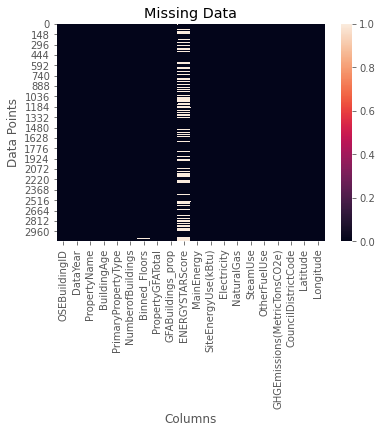

time: 550 ms (started: 2021-01-10 08:12:45 +00:00)


In [11]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

We can see from above that we have some missing data points, but it is not extensive and it mainly concerns the energystar score feature.

We will now process these missing data points

In [12]:
df.loc[df['Binned_Floors'].isnull()]

,OSEBuildingID,DataYear,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
154,267,2015,PINE ST. CONDO-ELLIOTT GRAND HYATT SEATTLE,16,Hotel,1.0,NaN,934292,1.000000,NaN,Electricity,63811044.00,0.621648,0.378378,0.000000,0.0,1558.85,7,47.612677,-122.333932
464,656,2015,1221 MADISON STREET (FORMER ARNOLD MED. PAVILLON),11,Office,1.0,NaN,225982,1.000000,61.0,Electricity,18558162.00,0.635452,0.000000,0.364574,0.0,604.45,3,47.609680,-122.323105
465,657,2015,2200 WESTLAKE,9,Other,1.0,NaN,516407,1.000000,19.0,Electricity,48981052.00,0.610087,0.389938,0.000000,0.0,1222.69,7,47.617939,-122.337387
536,758,2015,PACIFIC PLACE,16,Other,1.0,NaN,947987,0.535663,NaN,Electricity,48143224.00,1.000041,0.000000,0.000000,0.0,335.63,7,47.612874,-122.335276
1137,24086,2015,KING COUNTY METRO TRANSIT ATLANTIC-CENTRAL BAS...,24,Other,10.0,NaN,180796,1.000000,NaN,Electricity,29939196.00,0.558467,0.441556,0.000000,0.0,818.66,2,47.591130,-122.323399
1538,40028,2015,"SAND POINT BUILDING 5A,5B,5C,5D",75,Warehouse,1.0,NaN,384772,1.000000,65.0,Electricity,15411831.00,0.579122,0.420902,0.000000,0.0,406.74,4,47.683844,-122.261760
1539,40031,2015,SAND POINT BUILDING 25,55,Office,1.0,NaN,30287,1.000000,56.0,Electricity,1976647.00,0.845482,0.154553,0.000000,0.0,27.88,4,47.682195,-122.262390
1540,40034,2015,SAND POINT BUILDING 29,55,Office,1.0,NaN,21931,1.000000,21.0,NaturalGas,3732139.00,0.351837,0.648178,0.000000,0.0,137.63,4,47.682195,-122.262946
1546,43948,2015,GEORGETOWN STEAM PLANT,109,Other,1.0,NaN,39212,1.000000,NaN,Electricity,773013.00,1.000041,0.000000,0.000000,0.0,5.39,2,47.561588,-122.316071
1555,49705,2015,MAGNUSON PARK CAMPUS,86,Other,7.0,NaN,502030,1.000000,NaN,Electricity,17290816.00,0.558767,0.441256,0.000000,0.0,472.56,4,47.683179,-122.258795


time: 40.9 ms (started: 2021-01-10 08:12:45 +00:00)


In [13]:
df.loc[df["OSEBuildingID"] == 267,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 656,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 657,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 758,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 21611,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 24086,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 40028,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 40031,"Binned_Floors"] = 3
df.loc[df["OSEBuildingID"] == 40034,"Binned_Floors"] = 3
df.loc[df["OSEBuildingID"] == 49705,"Binned_Floors"] = 1
df.loc[df["OSEBuildingID"] == 43948,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 49958,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 49966,"Binned_Floors"] = 1
df.loc[df["OSEBuildingID"] == 23311,"Binned_Floors"] = 4

time: 23.9 ms (started: 2021-01-10 08:12:45 +00:00)


In [14]:
df = df[df.ENERGYSTARScore.notna()]
df.shape

(2065, 20)

time: 4.89 ms (started: 2021-01-10 08:12:45 +00:00)


In [15]:
print(df.isnull().sum())

OSEBuildingID                   0
DataYear                        0
PropertyName                    0
BuildingAge                     0
PrimaryPropertyType             0
NumberofBuildings               0
Binned_Floors                   0
PropertyGFATotal                0
GFABuildings_prop               0
ENERGYSTARScore                 0
MainEnergy                      0
SiteEnergyUse(kBtu)             0
Electricity                     0
NaturalGas                      0
SteamUse                        0
OtherFuelUse                    0
GHGEmissions(MetricTonsCO2e)    0
CouncilDistrictCode             0
Latitude                        0
Longitude                       0
dtype: int64
time: 4.02 ms (started: 2021-01-10 08:12:45 +00:00)


## 2. EDA

### Panda Profiling

In [16]:
#profile = ProfileReport(df, title="Heart Dataset", html={'style': {'full_width' : True}})

time: 1.88 ms (started: 2021-01-10 08:12:45 +00:00)


In [17]:
#profile.to_notebook_iframe()

time: 792 µs (started: 2021-01-10 08:12:45 +00:00)


### 2.1 Univariate Analysis: Numerical Variable

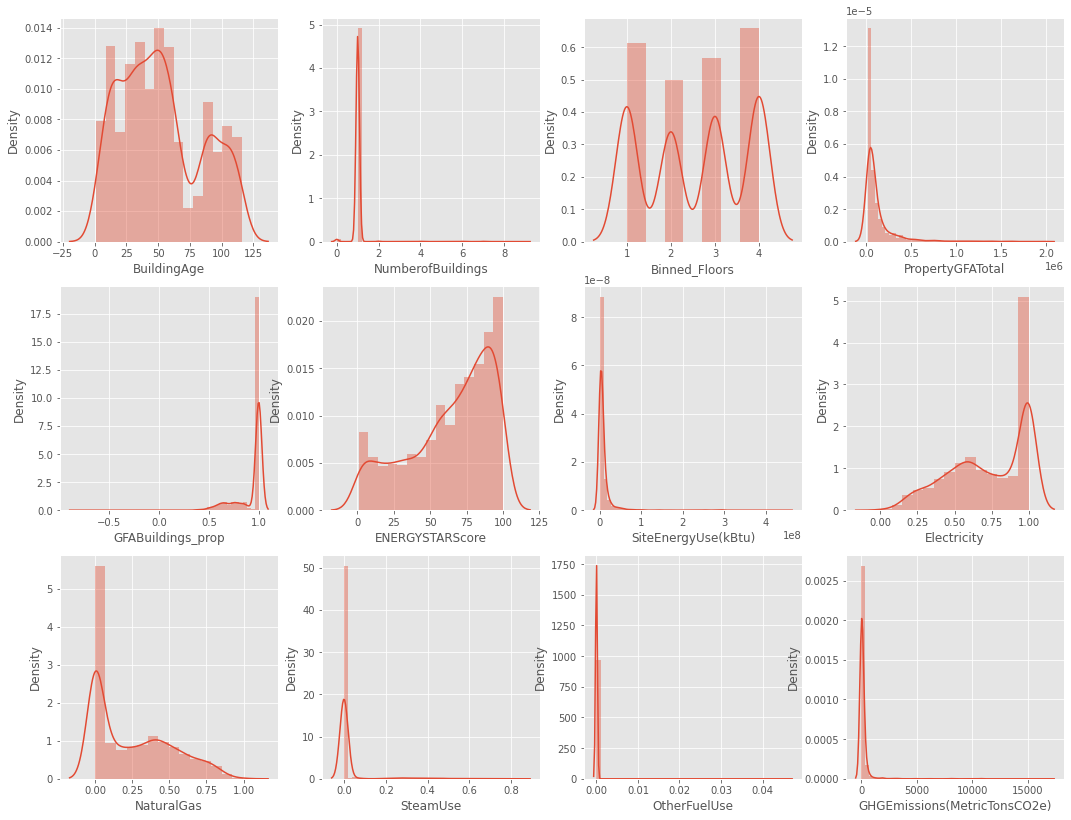

time: 2.97 s (started: 2021-01-10 08:12:45 +00:00)


In [18]:
def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(df, ["BuildingAge","NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"])


matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]


### 2.2 Univariate Analysis: Categorical Variables


[Text(0, 0, 'Office'),
 Text(0, 0, 'Warehouse'),
 Text(0, 0, 'Supermarket/Grocery/Retail Store'),
 Text(0, 0, 'School/University'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'Worship Facility'),
 Text(0, 0, 'Distribution Center'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Hospital/Laboratory'),
 Text(0, 0, 'Restaurant')]

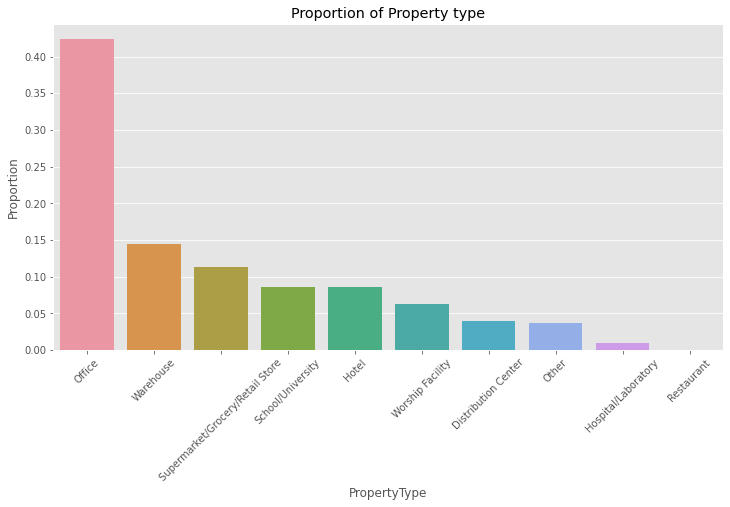

time: 271 ms (started: 2021-01-10 08:12:48 +00:00)


In [19]:
x, y = "PropertyType", "Proportion"

prop_df = (df["PrimaryPropertyType"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Property type')
g.set_xticklabels(g.get_xticklabels(),rotation=45)

[Text(0.5, 1.0, 'Proportion of Main Energy type')]

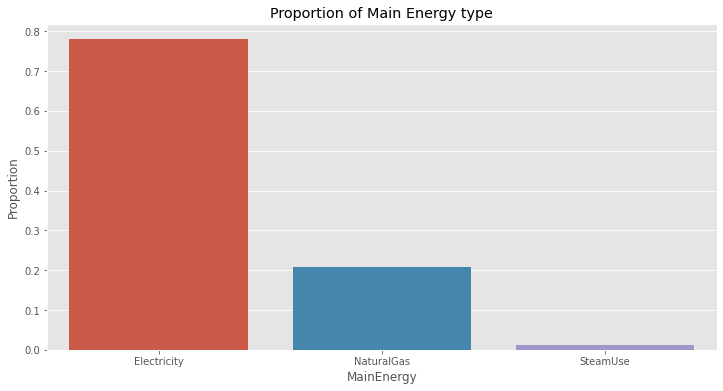

time: 178 ms (started: 2021-01-10 08:12:49 +00:00)


In [20]:
x, y = "MainEnergy", "Proportion"

prop_df = (df["MainEnergy"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Main Energy type')

### 2.3 Multivariate Analysis: Categorical vs Numerical Variables 

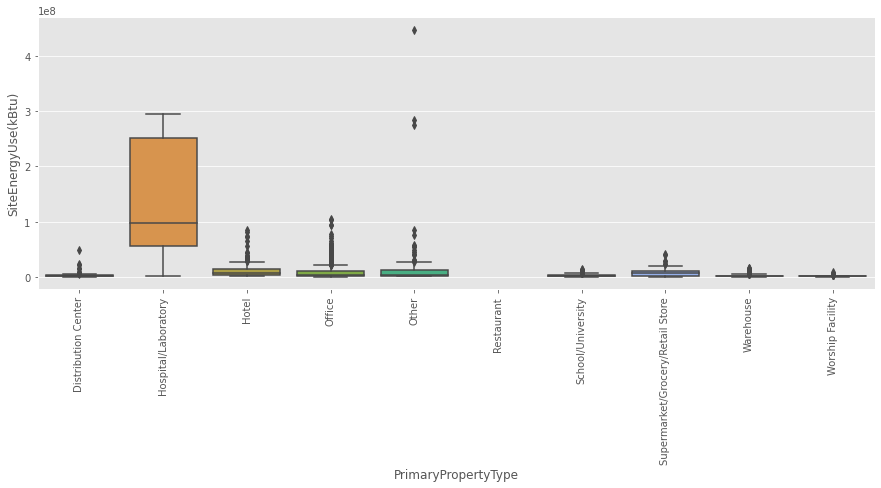

time: 286 ms (started: 2021-01-10 08:12:49 +00:00)


In [21]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

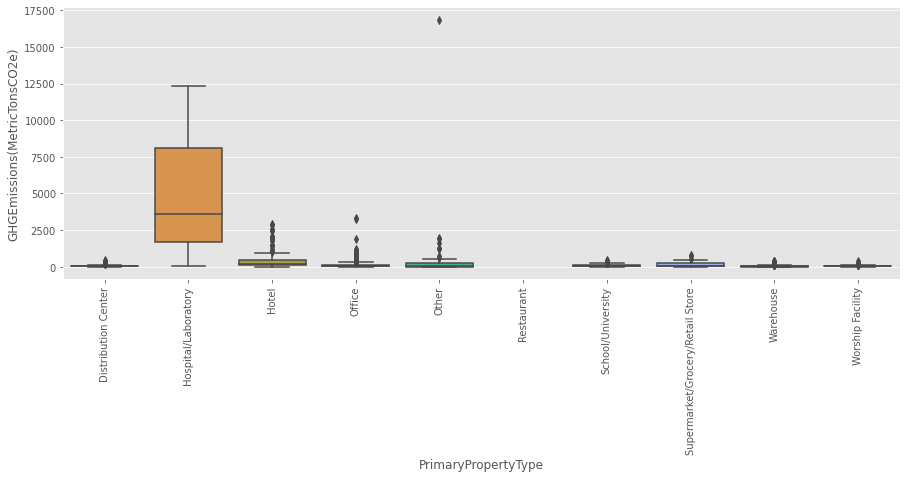

time: 308 ms (started: 2021-01-10 08:12:49 +00:00)


In [22]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

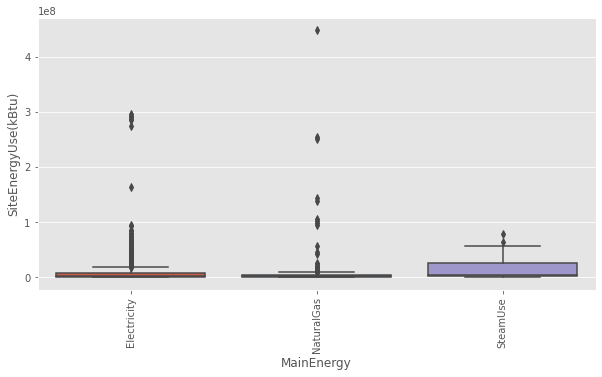

time: 182 ms (started: 2021-01-10 08:12:49 +00:00)


In [23]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

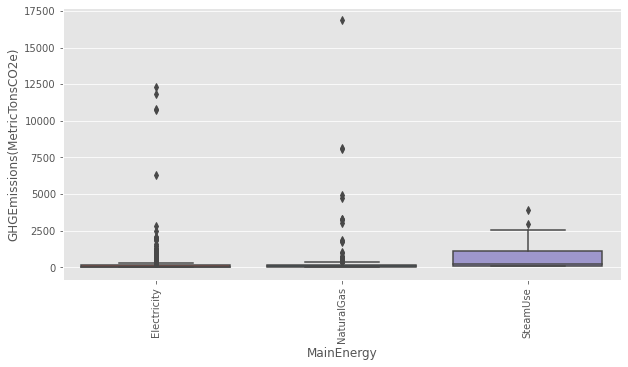

time: 273 ms (started: 2021-01-10 08:12:50 +00:00)


In [24]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

### 2.4 Geographical Analysis


#### *Heatmap*

In [25]:
def get_center_latlong(df):
    # get the center of my map for plotting
    centerlat = (df['Latitude'].max() + df['Latitude'].min()) / 2
    centerlong = (df['Longitude'].max() + df['Longitude'].min()) / 2
    return centerlat, centerlong

time: 2.34 ms (started: 2021-01-10 08:12:50 +00:00)


In [26]:
def generateBaseMap(center = get_center_latlong(df), default_zoom_start=11.5):
    base_map = folium.Map(location = center, control_scale=True, zoom_start=default_zoom_start)
    return base_map

time: 2.38 ms (started: 2021-01-10 08:12:50 +00:00)


In [27]:
from folium.plugins import HeatMap
df['count'] = 1
base_map = generateBaseMap()
HeatMap(data = df[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

time: 167 ms (started: 2021-01-10 08:12:50 +00:00)


#### *Choropleth Map*

In [28]:
boundary_file = '/content/drive/My Drive/OC_DataScientist/P4/Seattle-council-districts.geojson'
with open(boundary_file, 'r') as f:
    district_boundary = json.load(f)

time: 448 ms (started: 2021-01-10 08:12:50 +00:00)


In [29]:
# this line just to force our dataset zipcodes from numbers to strings so they match our geojson file
df['CouncilDistrictCode'] = pd.to_numeric(df.CouncilDistrictCode, errors='coerce')

# Grab my map center again using our created function (same as before)
center = get_center_latlong(df)


# Initialize Folium Map again (same as before)
seattle_map = folium.Map(location=center, zoom_start=11.5)

# Use the groupby method to have the mean of energy use by district
district_data = df.groupby('CouncilDistrictCode').aggregate(np.mean)
district_data.reset_index(inplace = True)

# Create choropleth map  
folium.Choropleth(
    geo_data=district_boundary,
    name='choropleth',
    data=district_data,
    columns=['CouncilDistrictCode', 'SiteEnergyUse(kBtu)'],
    key_on='feature.properties.district',
    fill_color='Spectral',
    fill_opacity=0.60,
      nan_fill_opacity=0,
    line_opacity=0.5,
    legend_name='Energy Use (kBtu)').add_to(seattle_map)

display(seattle_map)

time: 45.6 ms (started: 2021-01-10 08:12:50 +00:00)


### 2.4 Correlation


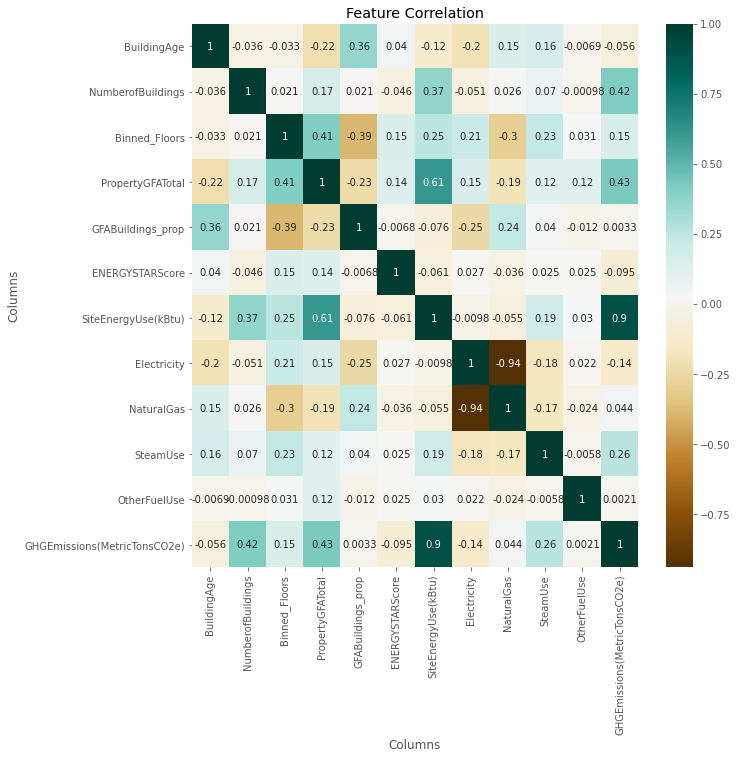

time: 833 ms (started: 2021-01-10 08:12:51 +00:00)


In [30]:
df_corr = df[["BuildingAge", "NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"]]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_corr.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

- High correlation between SiteEnergyUse(kBtu) and GHGEmissions(MetricTonsCO2e)
- High correlation between NaturalGas and Electricity
- Medium correlation between energy use and the property GFA total



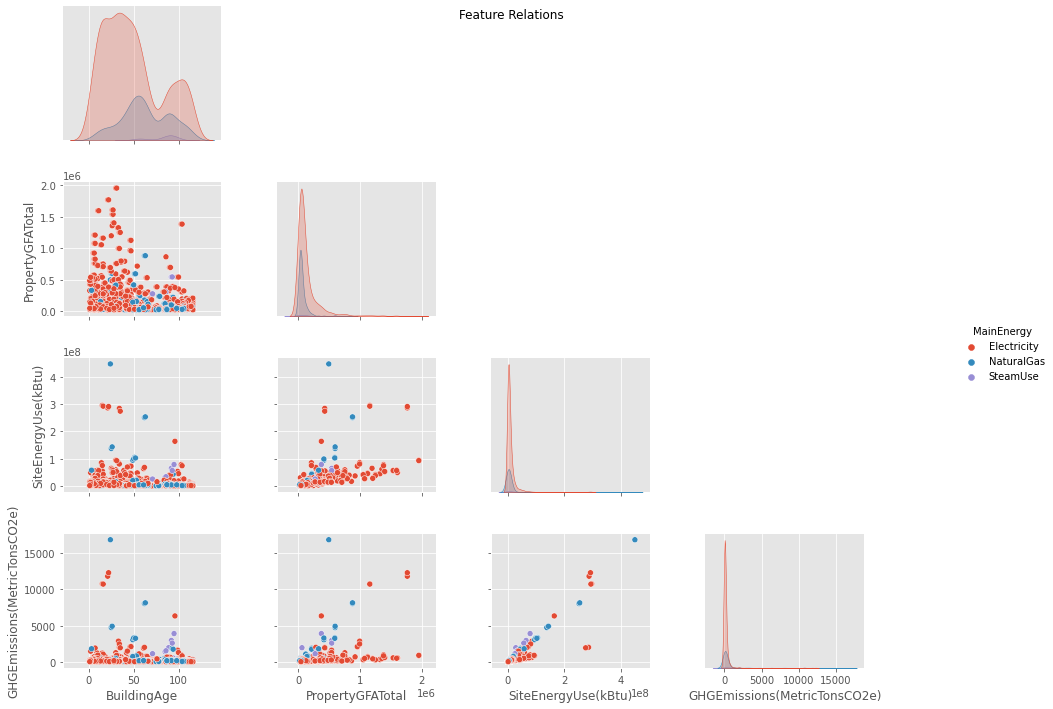

time: 4.61 s (started: 2021-01-10 08:12:51 +00:00)


In [31]:
g = sns.pairplot(df[["BuildingAge", "PropertyGFATotal", "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "MainEnergy"]], hue = 'MainEnergy', corner = True)
g.fig.suptitle('Feature Relations')
g.fig.set_size_inches(15,10)
plt.show()

## 3. Data Pre-Conditioning¶

In this section we will make our data ready for model training. This will include:

1. Transform our categorical column into numerical values.
2. Split data set into training and testing parts (80/20), while dropping the category column (string, and not going to be used to train the models), and separating cateogrical, where it will be used as labels.
3. We will try different splits of our dataset : with/without feature logging ; with.without duplicates.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 3086
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OSEBuildingID                 2065 non-null   int64   
 1   DataYear                      2065 non-null   int64   
 2   PropertyName                  2065 non-null   category
 3   BuildingAge                   2065 non-null   int64   
 4   PrimaryPropertyType           2065 non-null   category
 5   NumberofBuildings             2065 non-null   float64 
 6   Binned_Floors                 2065 non-null   float64 
 7   PropertyGFATotal              2065 non-null   int64   
 8   GFABuildings_prop             2065 non-null   float64 
 9   ENERGYSTARScore               2065 non-null   float64 
 10  MainEnergy                    2065 non-null   category
 11  SiteEnergyUse(kBtu)           2065 non-null   float64 
 12  Electricity                   2065 non-null   fl

#### *Features Selection*

In [33]:
df_final = df[["OSEBuildingID", "DataYear", "BuildingAge", "PrimaryPropertyType", "NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "MainEnergy", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"]]

time: 5.4 ms (started: 2021-01-10 08:12:56 +00:00)


#### *PrimaryPropertyType Transform*

In [34]:
df_final = pd.get_dummies(df_final, drop_first=True)
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 3086
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   OSEBuildingID                                         2065 non-null   int64  
 1   DataYear                                              2065 non-null   int64  
 2   BuildingAge                                           2065 non-null   int64  
 3   NumberofBuildings                                     2065 non-null   float64
 4   Binned_Floors                                         2065 non-null   float64
 5   PropertyGFATotal                                      2065 non-null   int64  
 6   GFABuildings_prop                                     2065 non-null   float64
 7   ENERGYSTARScore                                       2065 non-null   float64
 8   SiteEnergyUse(kBtu)                                   2065

In [35]:
df_final.head(5)

,OSEBuildingID,DataYear,BuildingAge,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),PrimaryPropertyType_Hospital/Laboratory,PrimaryPropertyType_Hotel,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Restaurant,PrimaryPropertyType_School/University,PrimaryPropertyType_Supermarket/Grocery/Retail Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,MainEnergy_NaturalGas,MainEnergy_SteamUse
0,1,2015,88,1.0,4.0,88434,1.000000,65.0,6981428.0,0.527995,0.182253,0.289773,0.0,249.43,0,1,0,0,0,0,0,0,0,0,0
1,2,2015,19,1.0,4.0,103566,0.854547,51.0,8354235.0,0.467477,0.532542,0.000000,0.0,263.51,0,1,0,0,0,0,0,0,0,1,0
2,3,2015,46,1.0,4.0,961990,1.000000,18.0,73130656.0,0.680459,0.050730,0.268839,0.0,2061.48,0,1,0,0,0,0,0,0,0,0,0
3,5,2015,89,1.0,4.0,61320,1.000000,1.0,28229320.0,0.098090,0.070915,0.830998,0.0,1936.34,0,1,0,0,0,0,0,0,0,0,1
4,8,2015,35,1.0,4.0,119890,0.896071,67.0,14829099.0,0.409077,0.590940,0.000000,0.0,507.70,0,1,0,0,0,0,0,0,0,1,0


time: 23.6 ms (started: 2021-01-10 08:12:56 +00:00)


#### *Data Split 1: With Duplicates ; Without logging of high variance features*

In [36]:
y = df_final['SiteEnergyUse(kBtu)']
X = df_final.drop(['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)','OSEBuildingID', 'DataYear'], axis=1)
seed = 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

time: 10.3 ms (started: 2021-01-10 08:12:56 +00:00)


#### *Data Split 2: With Duplicates ; With logging of high variance features*

In [37]:
df_final.var().sort_values(ascending=False).head(5)

SiteEnergyUse(kBtu)             5.440853e+14
PropertyGFATotal                4.358025e+10
OSEBuildingID                   1.689412e+08
GHGEmissions(MetricTonsCO2e)    5.681782e+05
BuildingAge                     1.007742e+03
dtype: float64

time: 17.1 ms (started: 2021-01-10 08:12:56 +00:00)


In [38]:
df_final2 = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final2[i + '_log'] = np.log(df_final2[i])
    df_final2.drop(i, axis=1, inplace=True)

y2 = df_final2['SiteEnergyUse(kBtu)_log']
X2 = df_final2.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','OSEBuildingID', 'DataYear'], axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=seed)

time: 17.2 ms (started: 2021-01-10 08:12:56 +00:00)


#### *Data Split 3: Without Duplicates ; Without logging of high variance features*

In [39]:
df_final3 = df_final.sort_values(by=['OSEBuildingID', 'DataYear']).drop_duplicates('OSEBuildingID', keep='last')
y3 = df_final3['SiteEnergyUse(kBtu)']
X3 = df_final3.drop(['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)','OSEBuildingID', 'DataYear'], axis=1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=seed)

time: 14.6 ms (started: 2021-01-10 08:12:56 +00:00)


#### *Data Split 4: Without Duplicates ; With logging of high variance features*

In [40]:
df_final4 = df_final2.sort_values(by=['OSEBuildingID', 'DataYear']).drop_duplicates('OSEBuildingID', keep='last')
y4 = df_final4['SiteEnergyUse(kBtu)_log']
X4 = df_final4.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','OSEBuildingID', 'DataYear'], axis=1)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=seed)

time: 13.5 ms (started: 2021-01-10 08:15:12 +00:00)


### Functions

In [112]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('Ridge', Ridge(random_state=42)), 
          ('Lasso', Lasso(random_state=42)),
          ('RF', RandomForestRegressor(random_state=42)),
          ('XGBR', XGBRegressor(objective ='reg:linear', verbosity = 0, random_state=42))
          ]

    results = []
    names = []
    scoring = ['r2', 'neg_root_mean_squared_error', 'neg_mean_squared_error']

    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    
        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
    
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)

    return final

time: 14.6 ms (started: 2021-01-10 12:11:31 +00:00)


In [ ]:
def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

    fig.savefig(filename, dpi=500, quality=95, transparent=True)
    return ax

time: 20.8 ms (started: 2021-01-04 09:31:22 +00:00)


In [ ]:
def evaluate_estimators(X_train, X_test, y_train, y_test, estimators, cv=5, scoring='neg_root_mean_squared_error', target_name='target'):
    """Evalue les modèles en estimant les meilleurs hyperparamètres. Crée un PNG des résultats.

    Args:
        X_train (object): Données d'entrainements
        X_test (object): Données de tests
        y_train (object): Données d'entrainements
        y_test (object): Données de tests
        estimators (dict): Contient les modèles et les hyperparamètres à tester
        cv (int, optional): Nombre de cross-validation. Defaults to 5.
        scoring (str, optional): Métrique d'évaluation des modèles. Defaults to 'neg_root_mean_squared_error'.
        target_name (str, optional): Nom de la cible. Defaults to 'target'.

    Returns:
        None
    """
    
    results = pd.DataFrame()
    for estim_name, estim, estim_params in estimators:
        print(f"{estim_name} en cours d'exécution...")
        model = GridSearchCV(estim, param_grid=estim_params, cv=cv, scoring=scoring, n_jobs=4)
        model.fit(X_train, y_train)

        # All regression plots
        #wandb.sklearn.plot_regressor(model, X_train, X_test, y_train, y_test,  model_name = estim_name)

        # Je stocke les résultats du GridSearchCV dans un dataframe
        model_results_df = pd.DataFrame(model.cv_results_)

        # Je sélectionne la meilleure observations
        model_results_df = model_results_df[model_results_df["rank_test_score"] == 1]

        # J'ajoute le nom du modéle et les résultats sur les données de test
        model_results_df[target_name] = estim_name
        model_results_df['Test : R2'] = r2_score(y_test, model.predict(X_test))
        model_results_df['Test : RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        model_results_df['Test : MAE'] = mean_absolute_error(y_test, model.predict(X_test))

        # Les hyperparamètres des estimateurs étant changeant, je crée un nouveau dataframe à partir de la colonne params           des résultats. Je jointe les 2 dataframes à partir des index. Cela me permet des flexible pour mon dataframe.
        model_results_df = pd.merge(model_results_df[[target_name, 'Test : MAE', 'Test : RMSE', 'Test : R2', 'mean_test_score', 'std_test_score']], 
                                 pd.DataFrame(model.cv_results_['params']), 
                                 left_index=True, right_index=True)
    
        # Je stocke les résultats dans un nouveau dataframe.
        results = results.append(model_results_df)

    
    export_png_table(round(results,4), filename='img_results_' + target_name + '.png')

    return None

time: 27.3 ms (started: 2021-01-04 09:31:27 +00:00)


## 4. Modelization of the energy use


In [119]:
final = run_exps(X_train, y_train, X_test, y_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (With duplicates, No logging):')
df_compare

Model Performance Comparison (With duplicates, No logging):


model,Lasso,RF,Ridge,XGBR
fit_time,3.348598e-02,7.415268e-01,3.627729e-03,1.026148e-01
score_time,2.641153e-03,1.386843e-02,2.427292e-03,2.907991e-03
test_r2,5.305125e-01,7.377564e-01,5.350520e-01,7.371985e-01
test_neg_root_mean_squared_error,-1.532223e+07,-1.196203e+07,-1.531118e+07,-1.182243e+07
test_neg_mean_squared_error,-2.797970e+14,-1.934585e+14,-2.794525e+14,-2.051576e+14


time: 5.62 s (started: 2021-01-10 12:16:03 +00:00)


In [120]:
final = run_exps(X2_train, y2_train, X2_test, y2_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (With duplicates, With logging):')
df_compare

Model Performance Comparison (With duplicates, With logging):


model,Lasso,RF,Ridge,XGBR
fit_time,0.006316,0.656023,0.004087,0.110958
score_time,0.002146,0.013940,0.002799,0.003306
test_r2,0.486716,0.881160,0.685297,0.872340
test_neg_root_mean_squared_error,-0.911860,-0.437274,-0.713669,-0.454023
test_neg_mean_squared_error,-0.833660,-0.191886,-0.511215,-0.207447


time: 5.02 s (started: 2021-01-10 12:16:09 +00:00)


In [116]:
final = run_exps(X3_train, y3_train, X3_test, y3_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (No duplicates, No logging):')
df_compare

model,Lasso,RF,Ridge,XGBR
fit_time,3.199172e-02,4.414229e-01,4.343510e-03,6.623626e-02
score_time,2.631235e-03,1.112952e-02,2.875280e-03,2.694798e-03
test_r2,3.813119e-01,4.940571e-01,4.604869e-01,7.431385e-02
test_neg_root_mean_squared_error,-1.460594e+07,-1.420013e+07,-1.456675e+07,-1.669698e+07
test_neg_mean_squared_error,-3.044053e+14,-2.940634e+14,-3.054730e+14,-3.531052e+14


time: 3.51 s (started: 2021-01-10 12:13:00 +00:00)


In [117]:
final = run_exps(X4_train, y4_train, X4_test, y4_test)
df_compare = final.groupby(['model']).mean().T
print('Model Performance Comparison (No duplicates, With logging):')
df_compare

model,Lasso,RF,Ridge,XGBR
fit_time,0.003367,0.398905,0.004042,0.063893
score_time,0.002209,0.010314,0.003357,0.002746
test_r2,0.479573,0.825317,0.676684,0.843365
test_neg_root_mean_squared_error,-0.918390,-0.531474,-0.723710,-0.503079
test_neg_mean_squared_error,-0.851168,-0.284330,-0.529485,-0.255282


time: 3.05 s (started: 2021-01-10 12:13:05 +00:00)


In [102]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')

    time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

values   -0.112554
dtype: float64

time: 38.4 ms (started: 2021-01-10 09:35:37 +00:00)


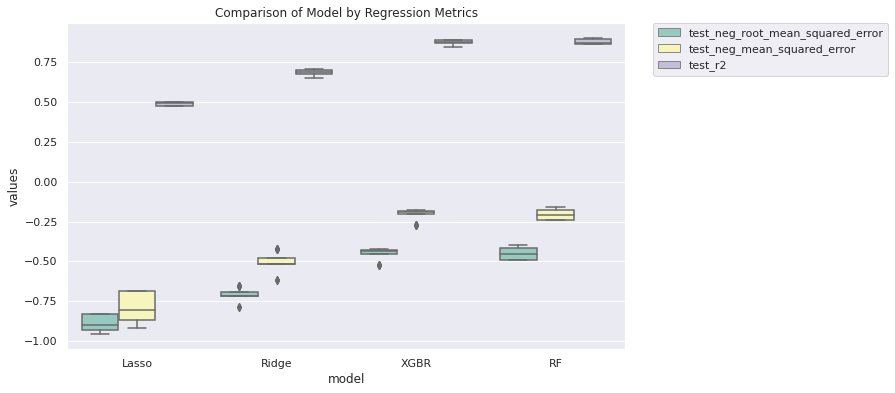

time: 1.12 s (started: 2021-01-10 09:34:33 +00:00)


In [99]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Regression Metrics')
plt.savefig('./benchmark_models_performance.png',dpi=300)

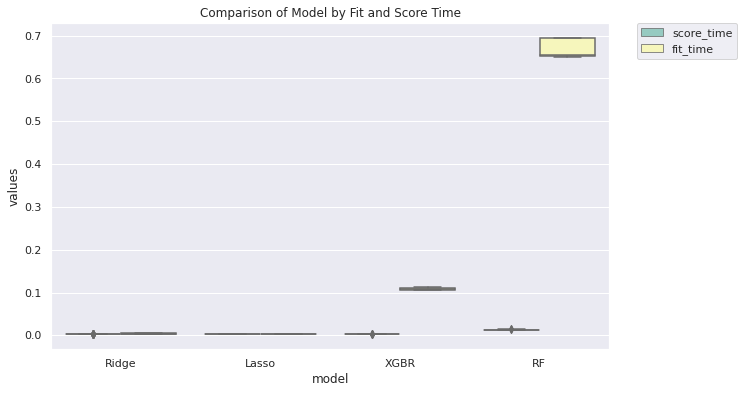

time: 1.05 s (started: 2021-01-10 09:34:44 +00:00)


In [100]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

##### Optimization
We will use grid search in order to obtain good parameters for our RF regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimize are:

- n-estimators
- min_samples_leaf
- max_depth
- max_features
- bootstrap

In [ ]:
rf_param_grid = {'bootstrap': [True],
    'max_depth': [50, 75, 100],
    'max_features': [10, 15, 25],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [200, 500, 1000]}

time: 4.69 ms (started: 2021-01-04 08:38:03 +00:00)


In [ ]:
rf_grid = GridSearchCV(estimator= RandomForestRegressor(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)

time: 3.47 ms (started: 2021-01-04 08:38:03 +00:00)


In [ ]:
rf_grid.fit(X2_train,y2_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

time: 7min 38s (started: 2021-01-04 08:38:03 +00:00)


In [ ]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 75,
 'max_features': 15,
 'min_samples_leaf': 3,
 'n_estimators': 1000}

time: 4.27 ms (started: 2021-01-04 08:45:42 +00:00)


In [ ]:
rf_opti = rf_grid.best_estimator_
rf_opti

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=75, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

time: 4.55 ms (started: 2021-01-04 08:45:42 +00:00)


In [ ]:
rf_grid_predictions = rf_opti.predict(X2_test)

time: 123 ms (started: 2021-01-04 08:45:42 +00:00)


MAE: 0.28760725424101263
RMSE: 0.41598562720122356
R2_Score:  0.9021269598167075


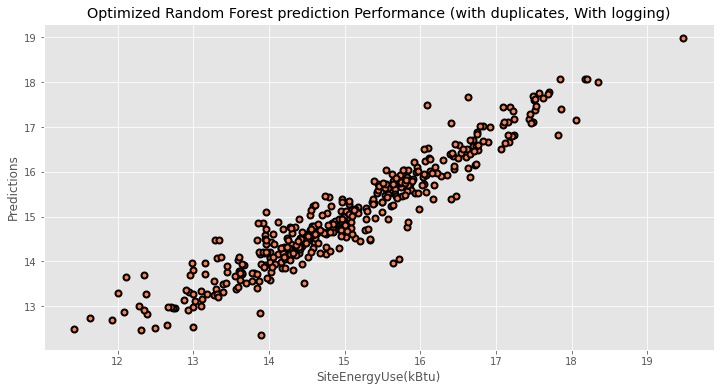

time: 208 ms (started: 2021-01-04 08:45:42 +00:00)


In [ ]:
print('MAE:', mean_absolute_error(y2_test, rf_grid_predictions))
print('RMSE:', np.sqrt(mean_squared_error(y2_test, rf_grid_predictions)))
print('R2_Score: ', r2_score(y2_test, rf_grid_predictions))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y2_test,rf_grid_predictions,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Optimized Random Forest prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

### Linear Regression 
We will use the result of the dummy regressor as a reference (other methods should have better results)

##### Model Training

In [ ]:
lm1 = LinearRegression()
lm1.fit(X_train,y_train)

lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)

lm3 = LinearRegression()
lm3.fit(X3_train,y3_train)

lm4 = LinearRegression()
lm4.fit(X4_train,y4_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

time: 23.5 ms (started: 2021-01-04 08:37:33 +00:00)


##### Predictions

In [ ]:
lm1_pred = lm1.predict(X_test)
lm2_pred = lm2.predict(X2_test)
lm3_pred = lm3.predict(X3_test)
lm4_pred = lm4.predict(X4_test)

time: 14.4 ms (started: 2021-01-04 08:37:33 +00:00)


##### Evaluation

Linear Regression Performance:

with duplicates, No logging:
MAE: 4562818.88528555
RMSE: 9485681.286619416
R2_Score:  0.7337967618131234

with duplicates, With logging:
MAE: 0.53691381243386
RMSE: 0.6835197948659213
R2_Score:  0.7357538791852323

no duplicates, No logging:
MAE: 4975332.951770531
RMSE: 17928395.627192423
R2_Score:  0.20004536513494175

no duplicates, With logging:
MAE: 0.5410075122311053
RMSE: 0.724453672671547
R2_Score:  0.6854118546234238


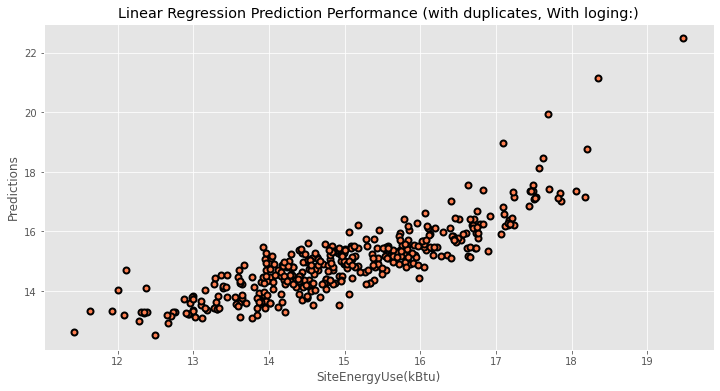

time: 272 ms (started: 2021-01-04 08:37:33 +00:00)


In [ ]:

print('Linear Regression Performance:')

print('\nwith duplicates, No logging:')
print('MAE:', mean_absolute_error(y_test, lm1_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, lm1_pred)))
print('R2_Score: ', r2_score(y_test, lm1_pred))

print('\nwith duplicates, With logging:')
print('MAE:', mean_absolute_error(y2_test, lm2_pred))
print('RMSE:', np.sqrt(mean_squared_error(y2_test, lm2_pred)))
print('R2_Score: ', r2_score(y2_test, lm2_pred))

print('\nno duplicates, No logging:')
print('MAE:', mean_absolute_error(y3_test, lm3_pred))
print('RMSE:', np.sqrt(mean_squared_error(y3_test, lm3_pred)))
print('R2_Score: ', r2_score(y3_test, lm3_pred))

print('\nno duplicates, With logging:')
print('MAE:', mean_absolute_error(y4_test, lm4_pred))
print('RMSE:', np.sqrt(mean_squared_error(y4_test, lm4_pred)))
print('R2_Score: ', r2_score(y4_test, lm4_pred))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y2_test,lm2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Linear Regression Prediction Performance (with duplicates, With loging:)') 
plt.grid(True)
plt.show()

From the metrics above, it is clear that logging and duplicates are essential for linear regression model training, in order to get acceptable results on this dataset. 

### Random Forest 

##### Training

In [ ]:
rf1 = RandomForestRegressor(random_state=101, n_estimators=200)
rf2 = RandomForestRegressor(random_state=101, n_estimators=200)
rf4 = RandomForestRegressor(random_state=101, n_estimators=200)

rf1.fit(X_train, y_train)
rf2.fit(X2_train, y2_train)
rf4.fit(X4_train, y4_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

time: 4.58 s (started: 2021-01-04 08:37:33 +00:00)


##### Predictions

In [ ]:
rf1_pred = rf1.predict(X_test)
rf2_pred = rf2.predict(X2_test)
rf4_pred = rf4.predict(X4_test)

time: 88.6 ms (started: 2021-01-04 08:37:38 +00:00)


##### Evaluation

Random Forest Performance:

With duplicates, No logging:
MAE: 2264987.3625283875
RMSE: 6766526.7212497685
R2_Score:  0.8645409955539943

With duplicates, With logging:
MAE: 0.25640635868101275
RMSE: 0.38192288687956144
R2_Score:  0.9174992689966255

No duplicates, With logging:
MAE: 0.34869122167497685
RMSE: 0.5186250161990865
R2_Score:  0.8387766136105423


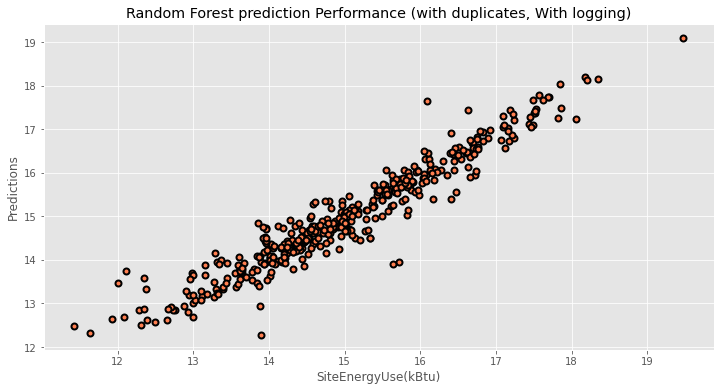

time: 230 ms (started: 2021-01-04 08:37:38 +00:00)


In [ ]:
print('Random Forest Performance:')

print('\nWith duplicates, No logging:')
print('MAE:', mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', r2_score(y_test, rf1_pred))

print('\nWith duplicates, With logging:')
print('MAE:', mean_absolute_error(y2_test, rf2_pred))
print('RMSE:', np.sqrt(mean_squared_error(y2_test, rf2_pred)))
print('R2_Score: ', r2_score(y2_test, rf2_pred))

print('\nNo duplicates, With logging:')
print('MAE:', mean_absolute_error(y4_test, rf4_pred))
print('RMSE:', np.sqrt(mean_squared_error(y4_test, rf4_pred)))
print('R2_Score: ', r2_score(y4_test, rf4_pred))

fig = plt.figure(figsize=(12, 6))

plt.scatter(y2_test,rf2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Random Forest prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

##### Feature Importance

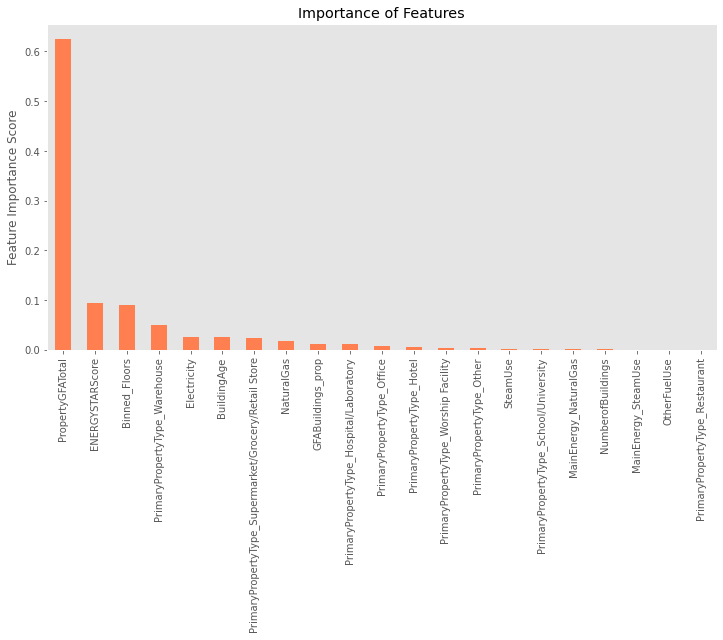

time: 515 ms (started: 2021-01-04 08:45:42 +00:00)


In [ ]:
feat_imp = pd.Series(rf_grid.best_estimator_.feature_importances_, list(X2_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

### Gradient Boosting

##### Training
We will first traing the GBM regressor with the default parameter values, then we will try optimizing its parameters.



In [ ]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)
gbm2 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)
gbm4 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)

gbm1.fit(X_train, y_train)
gbm2.fit(X2_train, y2_train)
gbm4.fit(X4_train, y4_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=101, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

time: 779 ms (started: 2021-01-04 08:45:42 +00:00)


##### Prediction


In [ ]:
gbm1_pred = gbm1.predict(X_test)
gbm2_pred = gbm2.predict(X2_test)
gbm4_pred = gbm4.predict(X4_test)

time: 10.8 ms (started: 2021-01-04 08:45:43 +00:00)


##### Evaluation


Gradiant Boosting Performance:

With duplicates, No logging:
MAE: 2666078.7911926033
RMSE: 7215984.723431578
R2_Score:  0.8459479481072798

With duplicates, With logging:
MAE: 0.32831426125389185
RMSE: 0.4427579221246456
R2_Score:  0.8891236019154514

No duplicates, With logging:
MAE: 0.32205973241008895
RMSE: 0.47742046340075167
R2_Score:  0.8633772017432781


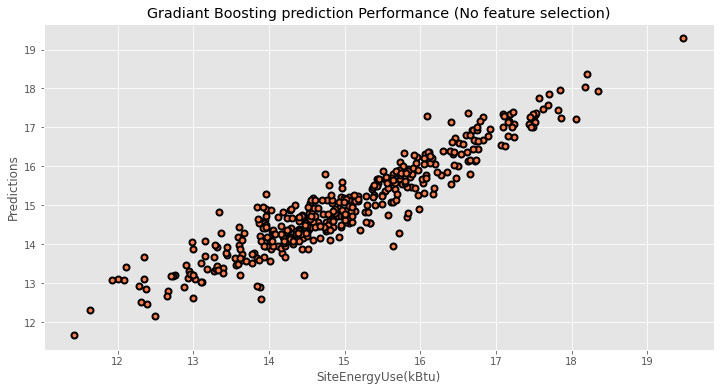

time: 228 ms (started: 2021-01-04 08:45:43 +00:00)


In [ ]:
print('Gradiant Boosting Performance:')

print('\nWith duplicates, No logging:')
print('MAE:', mean_absolute_error(y_test, gbm1_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, gbm1_pred)))
print('R2_Score: ', r2_score(y_test, gbm1_pred))

print('\nWith duplicates, With logging:')
print('MAE:', mean_absolute_error(y2_test, gbm2_pred))
print('RMSE:', np.sqrt(mean_squared_error(y2_test, gbm2_pred)))
print('R2_Score: ', r2_score(y2_test, gbm2_pred))

print('\nNo duplicates, With logging:')
print('MAE:', mean_absolute_error(y4_test, gbm4_pred))
print('RMSE:', np.sqrt(mean_squared_error(y4_test, gbm4_pred)))
print('R2_Score: ', r2_score(y4_test, gbm4_pred))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y2_test,gbm2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Gradiant Boosting prediction Performance (No feature selection)') 
plt.grid(True)
plt.show()

In [ ]:
# All regression plots
wandb.sklearn.plot_regressor(gbm2, X2_train, X2_test, y2_train, y2_test,  model_name='GradiantBoosting')

##### SUMMARY OF RESULTS

Ridge en cours d'exécution...
Lasso en cours d'exécution...
RandomForest en cours d'exécution...
XGBR en cours d'exécution...
[08:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GradientBoosting en cours d'exécution...


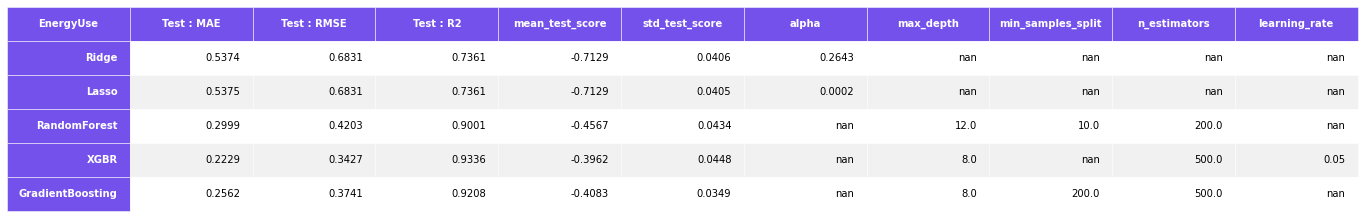

time: 4min 28s (started: 2021-01-04 08:45:43 +00:00)


In [ ]:

regressors = [('Ridge', Ridge(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]),

              ('Lasso', Lasso(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]), 

              ('RandomForest', RandomForestRegressor(random_state=seed), [{'max_depth': [4, 8, 12], 
                                                                           'min_samples_split': [10, 12, 14],
                                                                           'n_estimators': [50, 200, 500]}]),
              
              ('XGBR', XGBRegressor(random_state=seed), [{'max_depth': [4, 8, 12], 
                                                          'learning_rate': [0.05, 0.15, 0.30 ],
                                                          'n_estimators': [50, 200 , 500]}]),

              ('GradientBoosting', GradientBoostingRegressor(random_state=seed), [{'max_depth': [4, 6, 8,], 
                                                                                   'min_samples_split': [200, 500, 1000], 
                                                                                   'n_estimators': [50, 200, 500]}])]
                                                                                   
evaluate_estimators(X2_train, X2_test, y2_train, y2_test, regressors, cv=5, scoring='neg_root_mean_squared_error', target_name='EnergyUse')

## 4. Modelization of the CO2


In [ ]:
df_final_co2 = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final_co2[i + '_log'] = np.log(df_final_co2[i])
    df_final_co2.drop(i, axis=1, inplace=True)

y = df_final_co2['GHGEmissions(MetricTonsCO2e)_log']
X = df_final_co2.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','OSEBuildingID', 'DataYear'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

time: 13.8 ms (started: 2021-01-04 08:50:12 +00:00)


##### Training

In [ ]:
rf_co2 = RandomForestRegressor(random_state=101, n_estimators=200)
rf2_co2 = RandomForestRegressor(random_state=101, n_estimators=200)
rf_co2.fit(X_train, y_train)
rf_co2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

time: 3.23 s (started: 2021-01-04 08:57:25 +00:00)


##### Prediction

In [ ]:
rf_co2_pred = rf_co2.predict(X_test)

time: 39.1 ms (started: 2021-01-04 08:57:31 +00:00)


##### Evaluation

Random Forest Performance:

With duplicates, No logging:
MAE: 0.29346724729655305
RMSE: 0.42868242295636255
R2_Score:  0.9201102307888153


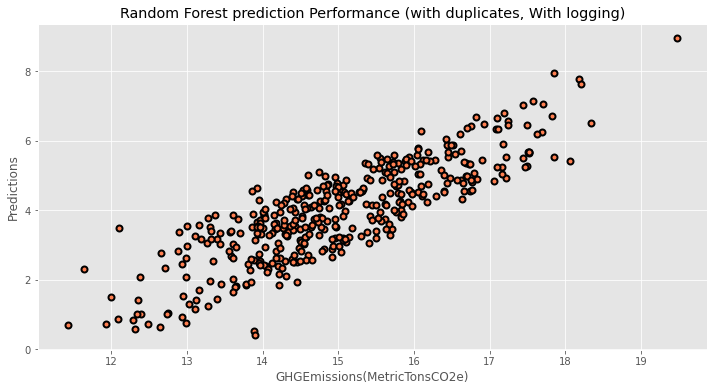

time: 210 ms (started: 2021-01-04 08:57:35 +00:00)


In [ ]:
print('Random Forest Performance:')

print('\nWith duplicates, No logging:')
print('MAE:', mean_absolute_error(y_test, rf_co2_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf_co2_pred)))
print('R2_Score: ', r2_score(y_test, rf_co2_pred))

fig = plt.figure(figsize=(12, 6))

plt.scatter(y2_test,rf_co2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('GHGEmissions(MetricTonsCO2e)') 
plt.ylabel('Predictions') 
plt.title('Random Forest prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

Features Importance

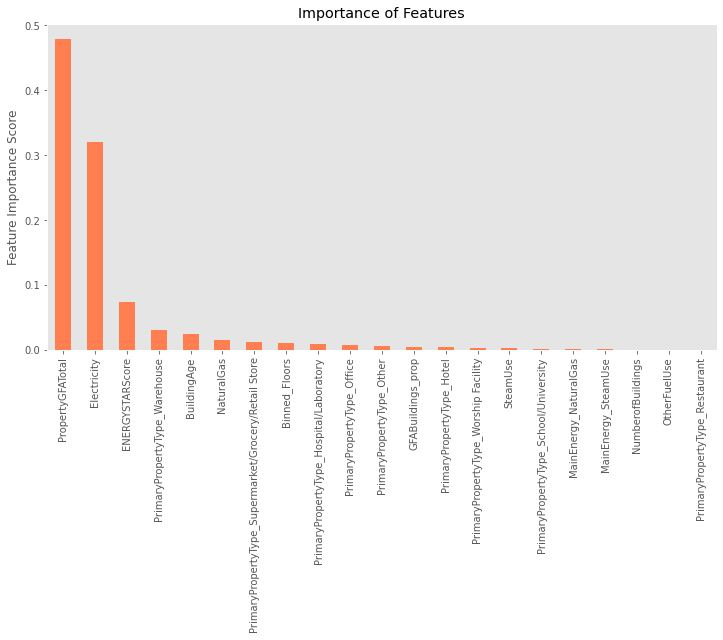

time: 313 ms (started: 2021-01-04 08:57:41 +00:00)


In [ ]:
feat_imp = pd.Series(rf_co2.feature_importances_, list(X_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

##### Summary

Ridge en cours d'exécution...
Lasso en cours d'exécution...
RandomForest en cours d'exécution...
XGBR en cours d'exécution...
[08:53:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GradientBoosting en cours d'exécution...


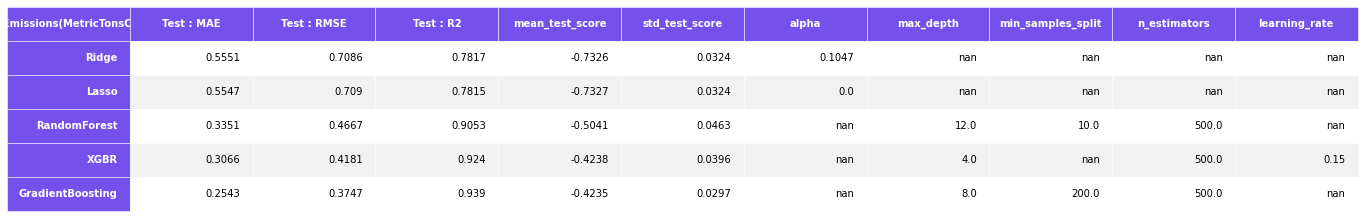

time: 4min 30s (started: 2021-01-04 08:50:12 +00:00)


In [ ]:

regressors = [('Ridge', Ridge(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]),

              ('Lasso', Lasso(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]), 

              ('RandomForest', RandomForestRegressor(random_state=seed), [{'max_depth': [4, 8, 12], 
                                                                           'min_samples_split': [10, 12, 14],
                                                                           'n_estimators': [50, 200, 500]}]),
              
              ('XGBR', XGBRegressor(random_state=seed), [{'max_depth': [4, 8, 12], 
                                                          'learning_rate': [0.05, 0.15, 0.30 ],
                                                          'n_estimators': [50, 200 , 500]}]),

              ('GradientBoosting', GradientBoostingRegressor(random_state=seed), [{'max_depth': [4, 6, 8,], 
                                                                                   'min_samples_split': [200, 500, 1000], 
                                                                                   'n_estimators': [50, 200, 500]}])]
                                                                                   
evaluate_estimators(X_train, X_test, y_train, y_test, regressors, cv=5, scoring='neg_root_mean_squared_error', target_name='GHGEmissions(MetricTonsCO2e)')

## 4. Modelization of the CO2 without the energy star score


In [ ]:
y = df_final_co2['GHGEmissions(MetricTonsCO2e)_log']
X = df_final_co2.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','ENERGYSTARScore', 'OSEBuildingID', 'DataYear'], axis=1)

model = RandomForestRegressor(random_state=101, n_estimators=200)

#By default, cv parameters assumes splits for StratifiedK-fold
cv_scores_5_folds = cross_val_score(model, X, y, cv=5)
#Specify K-Fold in cv parameter
#cv_scores_5_folds = cross_val_score(model, X, y, cv=KFold(n_splits=5))

cv_predicts_5_folds = cross_val_predict(model,X,y,cv=5)

print("Accuracy score in each iteration: {}".format(cv_scores_5_folds))
print("Predicted class for each record: {}".format(cv_predicts_5_folds))
print("K-Fold Score: {}".format(np.mean(cv_scores_5_folds)))
print("Total records: {}, Total predicted values: {}".format(df.shape[0],len(cv_predicts_5_folds)))

In [ ]:
df_final_co2_ES = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final_co2_ES[i + '_log'] = np.log(df_final_co2_ES[i])
    df_final_co2_ES.drop(i, axis=1, inplace=True)

y = df_final_co2_ES['GHGEmissions(MetricTonsCO2e)_log']
X = df_final_co2_ES.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log','ENERGYSTARScore', 'OSEBuildingID', 'DataYear'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

time: 18.7 ms (started: 2021-01-04 09:52:06 +00:00)


Ridge en cours d'exécution...
Lasso en cours d'exécution...
RandomForest en cours d'exécution...
XGBR en cours d'exécution...
[09:55:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GradientBoosting en cours d'exécution...


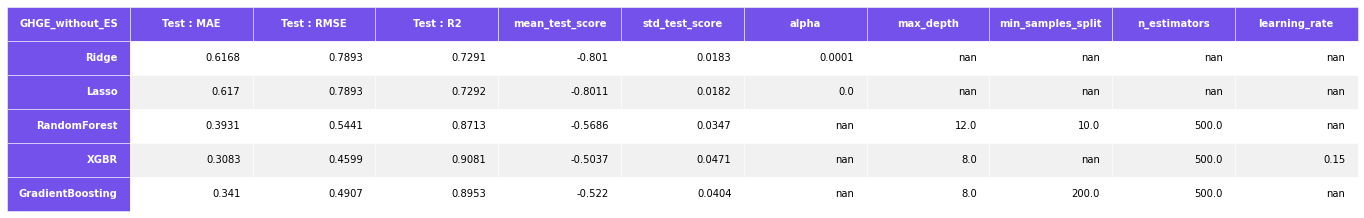

time: 4min 15s (started: 2021-01-04 09:52:11 +00:00)


In [ ]:
regressors = [('Ridge', Ridge(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]),

              ('Lasso', Lasso(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]), 

              ('RandomForest', RandomForestRegressor(random_state=seed), [{'max_depth': [4, 8, 12], 
                                                                           'min_samples_split': [10, 12, 14],
                                                                           'n_estimators': [50, 200, 500]}]),
              
              ('XGBR', XGBRegressor(random_state=seed), [{'max_depth': [4, 8, 12], 
                                                          'learning_rate': [0.05, 0.15, 0.30 ],
                                                          'n_estimators': [50, 200 , 500]}]),

              ('GradientBoosting', GradientBoostingRegressor(random_state=seed), [{'max_depth': [4, 6, 8,], 
                                                                                   'min_samples_split': [200, 500, 1000], 
                                                                                   'n_estimators': [50, 200, 500]}])]

evaluate_estimators(X_train, X_test, y_train, y_test, regressors, cv=5, scoring='neg_root_mean_squared_error', target_name='GHGE_without_ES')

CV sur les autres model

Metrics sur le temps pour la modelisation


start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))

Energy star score 